In [1]:
using Plots,LinearAlgebra,Interpolations, Random, Distributions, Roots, NLopt, ForwardDiff, LaTeXStrings, DifferentialEquations
gr()  #Load in packages
a=zeros(3); J=log(1); D=log(1); k=log(1/10); #Parameter estimates
x=LinRange(0,20,21);
xx=LinRange(0,20,201);
σ=1/2;

In [2]:
function model(x,a) #Solve BVP
y = Vector{eltype(a)}(undef, length(x))
J = exp(a[1]); D = exp(a[2]); k = exp(a[3])
c(x) = J*exp(-x*sqrt(k/D))/sqrt(D*k)
    for i in 1:length(x) 
    y[i] = c(x[i])
    end 
return y
end

model (generic function with 1 method)

In [3]:
#data0=zeros(length(x));
data=zeros(length(x));
#data0=model(x,[J,D,k]);
#data=data0.*exp.(σ*randn(length(x)));

data=[3.898952675812746  
2.569825438525737  
1.206631819080483  
1.3543817108830818 
0.6175527058221386 
0.30785528929186456
0.13649714414672498
0.6921031114954066 
0.271392505145547  
0.0945662375934022 
0.06039757137011752
0.1338145218277993 
0.1529291485263356
0.05189445084962129
0.02756210195622014
0.018066943988933968
0.017710583152626524
0.009164129234587067
0.008075081582671598
0.010557776318846062
0.004853780605374777]; #Data

In [4]:
function loglhood(data,a,σ) #Evaluate the log-normal loglikelihood
y=zeros(length(x))
y=model(x,a) # simulate deterministic model with parameters a
ℓ=0;
data_dists=[LogNormal(0,σ) for mi in y]; # LogNormal distribution
ℓ+=sum([loglikelihood(data_dists[i],data[i]./y[i]) for i in 1:length(data_dists)])  
return ℓ
end;

In [5]:
function funmle(a) #Evaluate the log-normal loglikelihood
return loglhood(data,a,σ)
end

funmle (generic function with 1 method)

In [6]:
function Optimise(fun,θ₀,lb,ub)     #Numerical optimization with NLopt and Nelder-Mead
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_NELDERMEAD,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = optimize(opt,θ₀)
    return res[[2,1]]
end;

  0.700933 seconds (1.80 M allocations: 97.487 MiB, 98.20% compilation time)


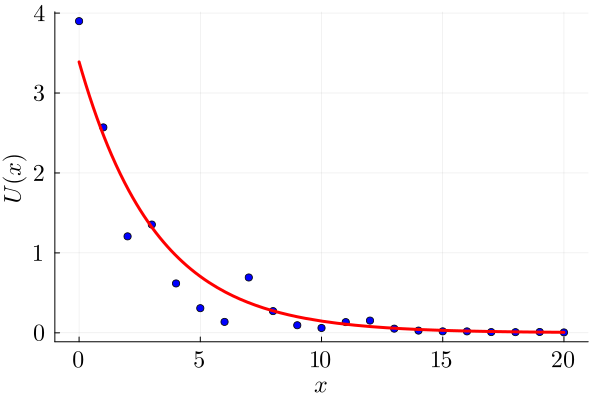

In [7]:
θG=[J, D, k] #Parameter estimates
lb=[-Inf,-Inf,-Inf]; ub=[Inf,Inf,Inf] #Bounds
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub) #Compute optimization
Jmle=exp(xopt[1]); Dmle=exp(xopt[2]); kmle=exp(xopt[3]); fmle=fopt
cmle(x) =  Jmle*exp(-x*sqrt(kmle/Dmle))/sqrt(Dmle*kmle)
p1=scatter(x,data,mc=:blue,msc=:match,label=false)
p1=plot!(cmle,xx[1],xx[end],color=:red,label=false,xlabel=L"x",ylabel=L"U(x)",xlims=(xx[1]-1,xx[end]+1),lw=3)
p1=plot!(xticks = ([0,5,10,15,20],  [L"0", L"5", L"10", L"15", L"20"]))
p1=plot!(yticks = ([0,1,2,3,4], [L"0", L"1", L"2", L"3", L"4"]))
p1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
#savefig(p1,"MorphogenGradient_MLE.pdf")
display(p1)

In [8]:
exp.(xopt)

3-element Vector{Float64}:
 1.248188423901186
 1.1727015794834863
 0.11566489347617002

In [9]:
ff(θ1,θ2,θ3) = funmle([θ1,θ2,θ3]) #Compute the observed Fisher Information at the MLE
H = -ForwardDiff.hessian(z -> ff(z[1],z[2],z[3]),xopt)

3×3 Matrix{Float64}:
   84.0       89.9035  -173.903
   89.9035   172.168   -262.071
 -173.903   -262.071    435.975

In [10]:
rank(H) #Compute the rank of the observed Fisher Information

2

In [11]:
(evals,evecs)=eigen(H) #Compute the eigenvectors and eigenvalues of the observed Fisher Information

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
3-element Vector{Float64}:
  -4.9514611578714095e-14
  28.85376823913323
 663.2889741272369
vectors:
3×3 Matrix{Float64}:
 0.57735  -0.751389   -0.319502
 0.57735   0.652391   -0.490971
 0.57735   0.0989975   0.810473

In [12]:
N=50 #Set up grids and bounds for the univariate profile likelihood function computation
Jmin=log(0.5); Jmax=log(5);
Dmin=log(0.5); Dmax=log(5);
kmin=log(0.05); kmax=log(0.2);
JJ=LinRange(Jmin,Jmax,N); DD=LinRange(Dmin,Dmax,N); kk=LinRange(kmin,kmax,N);

In [14]:
#Univariate Profiles
df=1
llstar=-quantile(Chisq(df),0.95)/2;

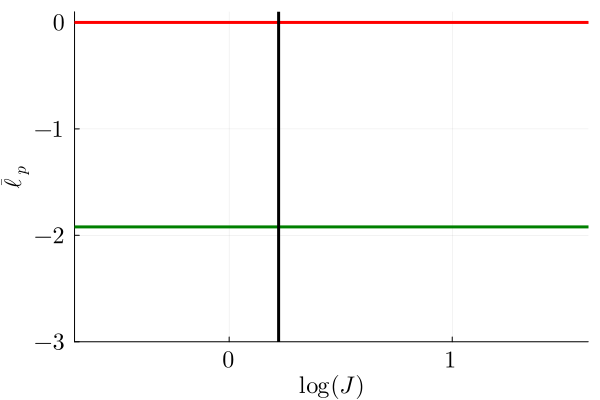

In [15]:
#Function to define univariate profile for J   
function UJ(J)
a=zeros(2)    
function funJ(a)
return loglhood(data,[J,a[1],a[2]],σ) 
end
θG=[log(Dmle),log(kmle)]
lb=[-Inf,-Inf]
ub=[Inf,Inf]
(xopt,fopt)=Optimise(funJ,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fJ(x) = UJ(x)[1]

q1=plot(fJ,JJ,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q1=hline!([llstar],legend=false,lw=3,lc=:green)
q1=vline!([log(Jmle)],lc=:black,legend=false,xlabel=L"\log(J)",ylabel=L"\bar{\ell}_p",lw=3)
q1=plot!(xlims=(minimum(JJ),maximum(JJ)),xticks=([0, 1],[L"0",L"1"]))
q1=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

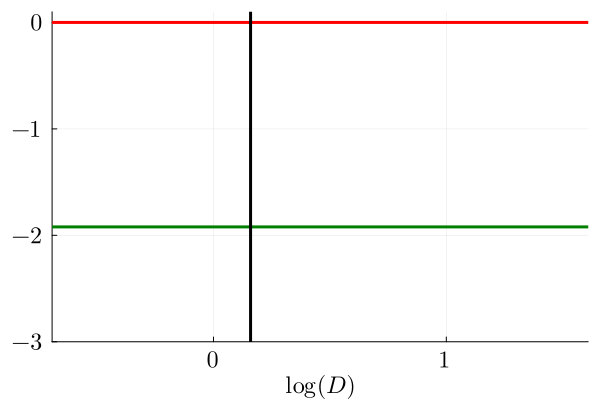

In [16]:
#Function to define univariate profile for D   
function UD(D)
a=zeros(2)    
function funD(a)
return loglhood(data,[a[1],D,a[2]],σ) 
end
θG=[log(Jmle),log(kmle)]
lb=[-Inf,-Inf]
ub=[Inf,Inf]
(xopt,fopt)=Optimise(funD,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fD(x) = UD(x)[1]

q2=plot(fD,DD,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q2=hline!([llstar],legend=false,lw=3,lc=:green)
q2=vline!([log(Dmle)],lc=:black,legend=false,xlabel=L"\log(D)",lw=3)
q2=plot!(xlims=(minimum(DD),maximum(DD)),xticks=([0, 1],[L"0",L"1"]))
q2=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q2=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)

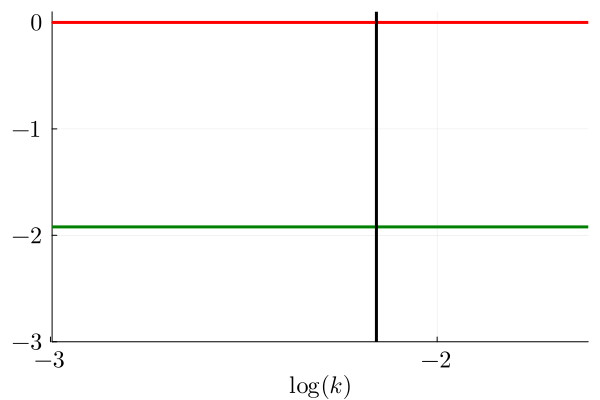

In [17]:
#Function to define univariate profile for k  
function Uk(k)
a=zeros(2)    
function funk(a)
return loglhood(data,[a[1],a[2],k],σ) 
end
θG=[log(Jmle),log(Dmle)]
lb=[-Inf,-Inf]
ub=[Inf,Inf]
(xopt,fopt)=Optimise(funk,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fk(x) = Uk(x)[1]

q3=plot(fk,kk,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q3=hline!([llstar],legend=false,lw=3,lc=:green)
q3=vline!([log(kmle)],lc=:black,legend=false,xlabel=L"\log(k)",lw=3)
q3=plot!(xlims=(minimum(kk),maximum(kk)),xticks=([-3, -2, -1],[L"-3",L"-2",L"-1"]))
q3=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q3=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)

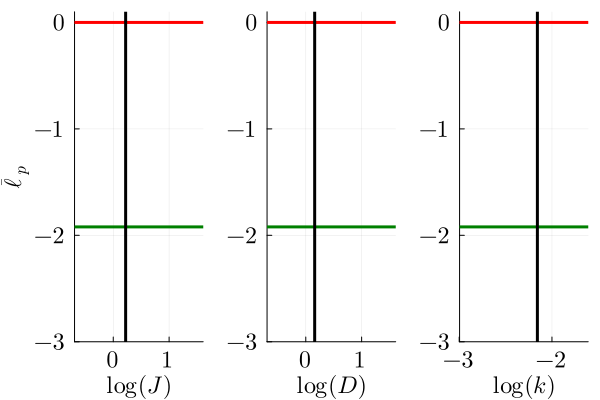

In [18]:
q4=plot(q1,q2,q3,layout=(1,3))
display(q4)

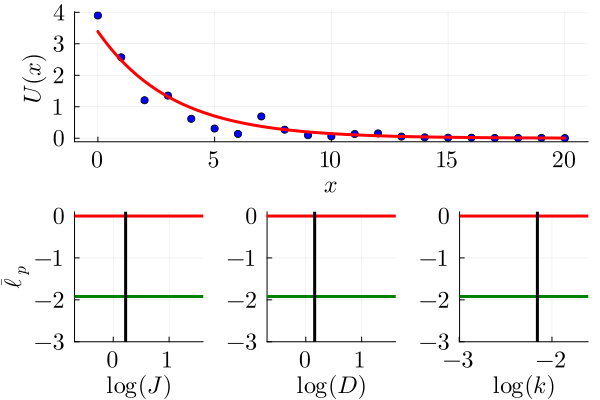

"C:\\Users\\matth\\Dropbox\\Model_Reduction\\Jupyter Notebooks\\Figure3.pdf"

In [20]:
s1=plot(p1,q4,layout=(2,1))
display(s1)
savefig(s1,"Figure3.pdf")